In [1]:
import numpy as np
import pandas as pd
import pickle
import time
import itertools

import matplotlib
matplotlib.rcParams.update({'font.size': 17.5})

import matplotlib.pyplot as plt
%matplotlib inline

matplotlib.rc('axes.formatter', useoffset=False)


import sys
import os.path
sys.path.append( os.path.abspath(os.path.join( os.path.dirname('..') , os.path.pardir )) )

In [2]:
from collapsingFLAMEbit import *
from genericFLAMEbit import *

reached threshold


In [3]:
def construct_sec_order(arr):
    ''' an intermediate data generation function used 
        for generating second order information '''
    
    second_order_feature = []
    num_cov_sec = len(arr[0])
    for a in arr:
        tmp = []
        for i in range(num_cov_sec):
            for j in range(i+1, num_cov_sec):
                tmp.append( a[i] * a[j] )
        second_order_feature.append(tmp)
        
    return np.array(second_order_feature)



In [4]:
def data_generation_dense_2(num_control, num_treated, num_cov_dense, 
                            num_covs_unimportant, control_m = 0.1,
                            treated_m = 0.9):
    
    ''' the data generating function that we will use; 
        includes second order information '''
    

    # generate data for control group 
    xc = np.random.binomial(1, 0.5, size=(num_control, num_cov_dense)) #bernouilli
    
    # generate data for treated group 
    xt = np.random.binomial(1, 0.5, size=(num_treated, num_cov_dense))   #bernouilli
     
    
    errors1 = np.random.normal(0, 0.1, size=num_control)    # some noise
    
    errors2 = np.random.normal(0, 0.1, size=num_treated)    # some noise
    
    dense_bs_sign = np.random.choice([-1,1], num_cov_dense) 
    
    dense_bs = [ np.random.normal(s * 10, 1) for s in dense_bs_sign ]   #alpha in the paper

    # y for control group 
    yc = np.dot(xc, np.array(dense_bs)) #+ errors1     
       
    # y for treated group 
    treatment_eff_coef = np.random.normal( 1.5, 0.15, size=num_cov_dense) #beta
    treatment_effect = np.dot(xt, treatment_eff_coef) 
    
    second = construct_sec_order(xt[:,:(num_covs_unimportant -1)])
    treatment_eff_sec = np.sum(second, axis=1)
    
    yt = np.dot(xt,np.array(dense_bs))+treatment_effect+treatment_eff_sec 
                                      # + errors2    

    # generate unimportant covariates for control group
    xc2 = np.random.binomial(1, control_m, size=(num_control,
                                                 num_covs_unimportant))  
    
    # generate unimportant covariates for treated group
    xt2 = np.random.binomial(1, treated_m, size=(num_treated,
                                                 num_covs_unimportant))   
        
    df1 = pd.DataFrame(np.hstack([xc, xc2]), 
                       columns=range(num_cov_dense + num_covs_unimportant))
    df1['outcome'] = yc
    df1['treated'] = 0

    df2 = pd.DataFrame(np.hstack([xt, xt2]), 
                       columns=range(num_cov_dense + num_covs_unimportant)) 
    df2['outcome'] = yt
    df2['treated'] = 1

    df = pd.concat([df1,df2])
    df['matched'] = 0
  
    return df, dense_bs, treatment_eff_coef




In [5]:
def compare_rows(treatment,control,covs):
    res = []
    for i in covs :
        if treatment[i] == control[i]:
            res.append(1)
        else:
            res.append(0)      
    return res   


In [12]:

def run_greedy(df,covs, w):
        
    
    treatments = df[df['treated']==1]
    controls = df[df['treated']==0]
    
    res = pd.DataFrame()
    cates = []
    #run over all treatments
    for i in range(len(treatments)):
        
        #get the treatment unit i
        cur_treatment = treatments.iloc[i]
        
        w_t = []
        for j in range(len(controls)):
            
            #get current control unit
            cur_control = controls.iloc[j]
            
            # find the v_tc
            v_tc = np.array(compare_rows(cur_treatment, cur_control, covs)  )
            
            #print v_tc
            w_tc = np.dot(v_tc,w)
            w_t.append((cur_control,w_tc))
            
        #now get the controls with the largest w_tc
        controls_c = max(w_t, key=itemgetter(1))
        best_control = controls_c[0]
        best_control = pd.DataFrame(data = best_control.values)
        best_control = best_control.transpose()
        best_control.columns = df.columns
        
        cur_treatment = pd.DataFrame(data = cur_treatment.values)
        cur_treatment = cur_treatment.transpose()
        cur_treatment.columns = df.columns
        
        group_t = pd.concat([cur_treatment,best_control])
        
        get_cate = group_t['outcome'].mean()
        cates.append(get_cate)
        res = pd.concat([res,group_t])
        
    return res, cates

In [7]:
#------- EXPERIMENT 1: N=3K, P=5 -----------------------------#

In [8]:
# data generation, set exponential to be True or False for exponential decay and power-law decay respectively

d = data_generation_dense_2(1500, 1500, 5,0, control_m = 0.1, treated_m = 0.9)
df = d[0] 
holdout,_,_ = data_generation_dense_2(1500, 1500, 5,0, control_m = 0.1, treated_m = 0.9)

In [9]:
#run generic flame til end
s = time.time()
res_gen = run_bit(df, holdout, range(5), [2]*5, threshold = -10, tradeoff_param = 0.1)
t_gen_p1 = time.time() - s

[0, 1, 2, 3, 4]
no more matches


In [10]:
# run collapsing flame til end
s = time.time()
res = run_mpbit(df, holdout, range(5), [2]*5, threshold =-10, tradeoff_param = 0.001)
t_col_p1 = time.time() - s

no more matches


In [11]:
s = time.time()
res_greedy = run_greedy(df, range(5), d[1])
t_greedy_p1 = time.time() - s

In [ ]:
#------- EXPERIMENT 2: N=3K, P=8 -----------------------------#


In [13]:
d1 = data_generation_dense_2(1500, 1500,8,0, control_m = 0.1, treated_m = 0.9)
df1 = d1[0] 
holdout1,_,_ = data_generation_dense_2(1500, 1500,8,0, control_m = 0.1, treated_m = 0.9)

In [15]:
s = time.time()
res1 = run_mpbit(df1, holdout1, range(8), [2]*8, threshold =-10, tradeoff_param = 0.001)
t_col_p2 = time.time() - s

no more matches


In [16]:
s = time.time()
res_gen1 = run_bit(df1, holdout1, range(8), [2]*8, threshold =-10, tradeoff_param = 0.001)
t_gen_p2 = time.time() - s

[0, 1, 2, 3, 4, 5, 6, 7]
no more matches


In [17]:
s = time.time()
res_greedy1 = run_greedy(df1, range(8), d1[1])
t_greedy_p2 = time.time() - s

In [18]:
#------- EXPERIMENT 3: N=3K, P=10 -----------------------------#


In [19]:
d2 = data_generation_dense_2(1500, 1500, 10,0, control_m = 0.1, treated_m = 0.9)
df2 = d2[0] 
holdout2,_,_ = data_generation_dense_2(1500, 1500, 10,0, control_m = 0.1, treated_m = 0.9)

In [20]:
s = time.time()
res_greedy2 = run_greedy(df2, range(10), d2[1])
t_greedy_p3 = time.time() - s


In [21]:
s = time.time()
res2 = run_mpbit(df2, holdout2, range(10), [2]*10, threshold =-10, tradeoff_param = 0.001)
t_col_p3 = time.time() - s

no more matches


In [22]:
s = time.time()
res_gen2 = run_bit(df2, holdout2, range(10), [2]*10, threshold =-10, tradeoff_param = 0.001)
t_gen_p3 = time.time() - s

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[0, 1, 2, 3, 4, 5, 6, 7, 9]
[0, 1, 3, 4, 5, 6, 7, 9]
[0, 1, 3, 4, 6, 7, 9]
[0, 1, 3, 4, 6, 7]
[0, 1, 4, 6, 7]
[0, 1, 6, 7]
[0, 1, 6]
[0, 6]


In [23]:
#--- create dataframe with all values---#

In [25]:

timescol = pd.DataFrame()
timesgen = pd.DataFrame()
timesgreedy = pd.DataFrame()

timescol['number of covariates'] = [5,8,10]
timescol['time'] = [t_col_p1,t_col_p2,t_col_p3]
timescol['method'] = ["Collapsing FLAME"]*3

timesgen['number of covariates'] = [5,8,10]
timesgen['time'] = [t_gen_p1,t_gen_p2,t_gen_p3]
timesgen['method'] = ["Generic FLAME"]*3

timesgreedy['number of covariates'] = [5,8,10]
timesgreedy['time'] = [t_greedy_p1,t_greedy_p2,t_greedy_p3]
timesgreedy['method'] = ["Greedy Approach"]*3


times = pd.concat([timescol, timesgen, timesgreedy])
times = times.round(2)
#times.to_csv('timings.csv')
times

,number of covariates,time,method
0,5,0.09,Collapsing FLAME
1,8,0.26,Collapsing FLAME
2,10,417.28,Collapsing FLAME
0,5,0.10,Generic FLAME
1,8,0.24,Generic FLAME
2,10,4.51,Generic FLAME
0,5,1427.24,Greedy Approach
1,8,1732.94,Greedy Approach
2,10,1692.04,Greedy Approach


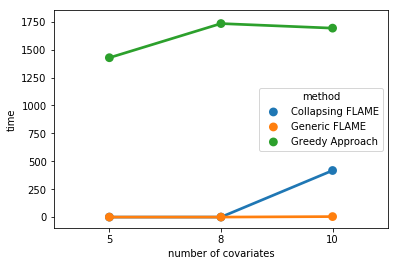

In [28]:
#---PLOT timing results -------#
import seaborn as sns
sns.pointplot(x="number of covariates", y="time",hue="method", data = times, fit_reg=False)
